## **A Comparative Study of LDA and BERT-Based Topic Modeling on Indonesian YouTube Protest Discourse**
#### an research for analyzing the performance of LDA and BERTopic on topic modelling for youtube comments for Indonesian DPR Dissolution Protest 

##### *Modeling & Analyzing*

In [1]:
import pandas as pd
import re
import nltk
import random
import numpy as np
import pickle

from nltk.tokenize import word_tokenize
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

nltk.download('punkt')
nltk.download('punkt_tab')

random.seed(42)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rofi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Rofi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [2]:
# Load Data

with open("LDA-dataset.pkl", "rb") as f:
    LDA_token = pickle.load(f)

with open("BERT-dataset.pkl", "rb") as f:
    BERT_token = pickle.load(f)

In [3]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

# Create dictionary & corpus
dictionary = corpora.Dictionary(LDA_token)
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in LDA_token]

# Train LDA
NUM_TOPICS = 5

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10
)

# Print topics
print("LDA Topics:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")

# Coherence score
lda_coherence = CoherenceModel(
    model=lda_model,
    texts=LDA_token,
    dictionary=dictionary,
    coherence='c_v'
).get_coherence()

print("LDA Coherence:", lda_coherence)


LDA Topics:
Topic 0: 0.047*"pak" + 0.024*"ini" + 0.023*"mahfud" + 0.022*"saya" + 0.015*"jadi" + 0.014*"partai" + 0.014*"orang" + 0.013*"dan" + 0.012*"yang" + 0.012*"presiden"
Topic 1: 0.019*"nya" + 0.013*"koruptor" + 0.012*"aset" + 0.012*"itu" + 0.011*"perampasan" + 0.011*"pajak" + 0.011*"aja" + 0.010*"mati" + 0.009*"juga" + 0.008*"ada"
Topic 2: 0.050*"rakyat" + 0.038*"dan" + 0.023*"yang" + 0.017*"tidak" + 0.015*"dpr" + 0.014*"untuk" + 0.013*"ini" + 0.013*"mereka" + 0.011*"itu" + 0.010*"negara"
Topic 3: 0.028*"jokowi" + 0.027*"ini" + 0.018*"bang" + 0.018*"dan" + 0.017*"guru" + 0.015*"anak" + 0.014*"allah" + 0.013*"pak" + 0.011*"aku" + 0.010*"semoga"
Topic 4: 0.091*"dpr" + 0.026*"gaji" + 0.023*"rakyat" + 0.020*"ada" + 0.020*"bubarkan" + 0.016*"anggota" + 0.015*"tunjangan" + 0.015*"bisa" + 0.015*"itu" + 0.014*"uang"
LDA Coherence: 0.5159651989030121


In [5]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

embedding_model = SentenceTransformer("indobenchmark/indobert-base-p1")

vectorizer_model = CountVectorizer(
    stop_words=None,     # JANGAN stopwords
    min_df=1,            # WAJIB 1
    max_df=0.95,         # aman
    ngram_range=(1, 2)
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    language="indonesian",
    verbose=True
)

docs_bertopic = BERT_token
topics, probs = topic_model.fit_transform(docs_bertopic)



c:\Users\Rofi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No sentence-transformers model found with name indobenchmark/indobert-base-p1. Creating a new one with mean pooling.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
2026-01-17 21:19:47,647 - BERTopic - Embedding - Transforming documents to embeddings.
Batches:   0%|          | 0/343 [00:00<?, ?it/s]Error w

In [ ]:
topics_dict = topic_model.get_topics()

# Convert BERTopic topics to lists of token IDs using the LDA dictionary
bertopic_topics_for_coherence = []
for topic_id, words_with_scores in topics_dict.items():
    if topic_id != -1:  # Exclude noise topic
        current_topic_word_ids = []
        for word_str, _ in words_with_scores:
            for sub_word in word_str.split(): # Split n-grams into single words
                if sub_word in dictionary.token2id:
                    current_topic_word_ids.append(dictionary.token2id[sub_word])

        if current_topic_word_ids: # Ensure the topic is not empty after filtering
            bertopic_topics_for_coherence.append(current_topic_word_ids)

bertopic_coherence = CoherenceModel(
    topics=bertopic_topics_for_coherence,
    texts=LDA_token,
    dictionary=dictionary,
    coherence='c_v'
).get_coherence()

print("BERTopic Coherence:", bertopic_coherence)


BERTopic Coherence: 0.6855950282018753


In [7]:
print("\n=== FINAL COMPARISON ===")
print(f"LDA Coherence (C_v): {lda_coherence:.4f}")
print(f"BERTopic Coherence (C_v): {bertopic_coherence:.4f}")



=== FINAL COMPARISON ===
LDA Coherence (C_v): 0.5160
BERTopic Coherence (C_v): 0.6856


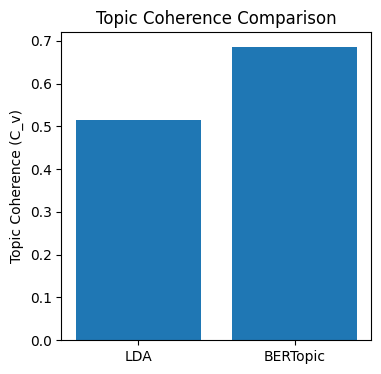

In [9]:
import matplotlib.pyplot as plt

models = ['LDA', 'BERTopic']
scores = [lda_coherence, bertopic_coherence]

plt.figure(figsize=(4,4))
plt.bar(models, scores)
plt.ylabel('Topic Coherence (C_v)')
plt.title('Topic Coherence Comparison')
plt.show()


In [10]:
topic_model.visualize_topics()


In [11]:
topic_model.visualize_hierarchy()
